# Collaborative Filtering

## Introduction

Introduction Recommendation systems are a collection of algorithms used to recommend items to users based on information taken from the user. These systems have become ubiquitous can be commonly seen in online stores, movies databases and job finders. In this notebook, we will explore recommendation systems based on Collaborative Filtering and implement simple version of one using Python and the Pandas library.

In this notebook was created for review recommendation system collaborative filltering that I lerned from IBM data science from coursera.

## Data

In this notebook we will use the data from kaggle [Anime Recommendation Database 2020](https://https://www.kaggle.com/hernan4444/anime-recommendation-database-2020?select=anime.csv) that contain :
- The anime list per user. Include dropped, complete, plan to watch, currently watching and on hold.
- Ratings given by users to the animes that they has watched completely.
- Information about the anime like genre, stats, studio, etc.
- HTML with anime information to do data scrapping. These files contain information such as reviews, synopsis, information about the staff, anime statistics, genre, etc.

This project we will use only 2 dataset anime.csv and rating_complete.csv for generate recommendation system model.


### Import Library

In [ ]:
#Dataframe manipulation library
import sys
import pandas as pd
#Math functions, we'll only need the sqrt function so let's import only that
from math import sqrt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install openpyxl

### Data Preprocessing

import animelist and rating dataset

In [ ]:
animecsv = pd.read_csv("../input/anime-recommendation-database-2020/anime.csv")
ratingcsv = pd.read_csv("../input/anime-recommendation-database-2020/rating_complete.csv")

In [ ]:
animecsv.shape

Show the data from animeCSV

In [ ]:
animecsv.head()

Due to there are many data in anime dataset so we need to fillter the data for make it faster to compute this coding.

In [ ]:
#Remove Unknown in score column and select only tv type 
anime_movie = animecsv[(animecsv["Score"] != "Unknown") & (animecsv["Type"] == "TV") ] 
anime_movie = anime_movie[anime_movie["Popularity"] <= 5000]
anime_movie.head()

In [ ]:
anime_movie.columns

In [ ]:
anime_movie.shape

In [ ]:
anime_movie_fillter = anime_movie[["MAL_ID","Name","Premiered","Popularity"]]
anime_movie_fillter.head()

In [ ]:
anime_movie_fillter['year'] = anime_movie_fillter.Premiered.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
anime_movie_fillter['year'] = anime_movie_fillter.Premiered.str.extract('(\d\d\d\d)',expand=False)

In [ ]:
anime_movie_fillter.head()

In [ ]:
anime_movie_fillter = anime_movie_fillter.rename(columns={'MAL_ID': 'anime_id'})

In [ ]:
anime_movie_fillter.head()

In [ ]:
anime_movie_fillter.describe()

In [ ]:
# Compute number of data points: n_data
n_data = len(anime_movie_fillter["Popularity"])

# Number of bins is the square root of number of data points: n_bins
n_bins =  np.sqrt(n_data)

# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Plot the histogram
plt.hist(anime_movie_fillter["Popularity"],bins = n_bins)

# Label axes
_ = plt.xlabel('Popularity')
_ = plt.ylabel('count')

# Show histogram
plt.show()

In [ ]:
#anime_movie_fillter = anime_movie_fillter[anime_movie_fillter["Popularity"] <= 5000]

In [ ]:
anime_movie_fillter.shape

# RatingCSV 

In [ ]:
ratingcsv.head()

# Collaborative Filtering

In [ ]:
userInput = [
            {'Name':'Sword Art Online','rating':7},
            {'Name':'Boku no Hero Academia', 'rating': 8},
            {'Name':'Naruto', 'rating':9},
            {'Name':"One Punch Man", 'rating':6},
            {'Name':'Major S6', 'rating':9}
         ] 
inputAnime = pd.DataFrame(userInput)
inputAnime

## Add anime_id to input user

In [ ]:
#Filtering out the animes by title
inputId = anime_movie_fillter[anime_movie_fillter['Name'].isin(inputAnime['Name'].tolist())]
#Then merging it so we can get the anime_id. It's implicitly merging it by title.
inputAnime = pd.merge(inputId, inputAnime)
#Dropping information we won't use from the input dataframe
#Final input dataframe
#If a anime you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputAnime

## The users who has seen the same animes

In [ ]:
#Filtering out users that have watched animes that the input has watched and storing it
userSubset = ratingcsv[ratingcsv['anime_id'].isin(inputAnime['anime_id'].tolist())]
userSubset.head()

We now group up the rows by user ID.

In [ ]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = userSubset.groupby(['user_id'])

In [ ]:
userSubsetGroup.head()

In [ ]:
type(userSubsetGroup)

Let's also sort these groups so the users that share the most anime in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.

In [ ]:
#Sorting it so users with anime most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Now lets look at the first user

In [ ]:
userSubsetGroup = userSubsetGroup[0:1000]

In [ ]:
type(userSubsetGroup)

In [ ]:
userSubsetGroup[0:3]

In [ ]:
userSubsetGroup[0]

## Similarity of users to input user

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

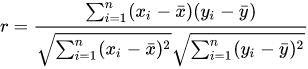

In [ ]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient คำนวณ
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='anime_id')
    inputAnime = inputAnime.sort_values(by='anime_id')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the anime that they both have in common
    temp_df = inputAnime[inputAnime['anime_id'].isin(group['anime_id'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    #ให้ x คือ 
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


In [ ]:
group.head(20)

In [ ]:
pearsonCorrelationDict.items()

In [ ]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['user_id'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF)) # reset index
pearsonDF.head(20)

## The top x similar users to input user

In [ ]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:100]
topUsers.head(20)

In [ ]:
topUsers.shape

## Rating of selected users to all Anime

In [ ]:
topUsersRating=topUsers.merge(ratingcsv, left_on='user_id', right_on='user_id', how='inner')
topUsersRating.head()

In [ ]:
topUsersRating.shape

Now all we need to do is simply multiply the anime rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by anime_id and then dividing two columns:

It shows the idea of all similar users to candidate anime for the input user:

In [ ]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

In [ ]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('anime_id').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

In [ ]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
#recommendation_df['anime_id'] = tempTopUsersRating.index
recommendation_df.head()

In [ ]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

# Result

In [ ]:
anime_recom =recommendation_df.merge(anime_movie_fillter, left_on='anime_id', right_on='anime_id', how='inner')
anime_recom.head(20)

## Result year after 2010

In [ ]:
anime_recom["year"] = pd.to_numeric(anime_recom['year'])
top10 = anime_recom[anime_recom["year"] >= 2010]
top10.head(10)